# Import Modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import * 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model

np.random.seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9392282167732370679
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7327445926142340785
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 41259759679099111
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4104245725024375484
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/PY/SemEval2021/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Data

In [2]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
stopwordEn = stopwords.words('english')
def lemmaWord(word):
    lemma = wordnet.morphy(word) 
    # lemmar = WordNetLemmatizer()
    # lemma = lemmar.lemmatize(word) 
    if lemma is not None:
        return lemma
    else:
        return word
def processText(text,lemma=False, gram=1, rmStop=True): # default remove stop words
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
    tokens = word_tokenize(text)
    whitelist = ["n't", "not", "no"]
    new_tokens = []
    stoplist = stopwordEn if rmStop else []
    for i in tokens:
      i = i.lower()
      if i not in ['.',',',';'] and (i not in stoplist or i in whitelist):  #i.isalpha() and (...)
        if lemma: i = lemmaWord(i)
        new_tokens.append(i)
    del tokens
    # tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stoplist or i.lower() in whitelist) and i.isalpha()]
    if gram<=1:
        return new_tokens
    else:
        return [' '.join(i) for i in nltk.ngrams(new_tokens, gram)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
data = pd.read_csv(PATH+"train.csv")
data.loc[:,'tokens'] = [processText(t, rmStop=True) for t in data.text]
data.loc[:,'token_len'] = [len(t) for t in data.tokens]
data['humor_rating'] = data['humor_rating'].fillna(0)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,id,text,is_humor,humor_rating,humor_controversy,offense_rating,tokens,token_len
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,"[tennessee, :, 're, best, state, nobody, even,...",17
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,"[man, inserted, advertisement, classifieds, ``...",24
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,"[many, men, take, open, beer, ?, none, open, t...",11
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,"[told, mom, hit, 1200, twitter, followers, poi...",17
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,"[roses, dead, love, fake, weddings, basically,...",8


Import from saved pickle

In [4]:
with open(PATH+'train_tokens.pickle', 'rb') as handle:
    data = pickle.load(handle)

# Tokenization


In [5]:
# Word Embedding
np.random.seed(1)
set_seed(2)
t = Tokenizer()
t.fit_on_texts([' '.join(i) for i in data['tokens']])

def encodeText(orig_tokens,max_len=0):  
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences([' '.join(i) for i in orig_tokens])
  max_length = max(list(map(lambda x: len(x), encoded_train))) if max_len==0 else max_len
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

X, vocab_size, max_length = encodeText(data['tokens'])
Y = to_categorical(data['is_humor'])
X.shape, vocab_size, max_length #((8000, 68), 14766, 68)

((8000, 68), 14766, 68)

## Pre-Trained GloVe Embedding
Download GloVe: https://drive.google.com/drive/folders/1HjR7uSYHPoC2qp2rUwgnz2mwdD63kYLf?usp=sharing

In [6]:
# load the whole embedding into memory
EMB_DIM = 50
embeddings_dict = {}
with open(PATH+F"./GLOVE/glove.twitter.27B.{EMB_DIM}d.txt", 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if len(vector)==EMB_DIM:
            embeddings_dict[word] = vector
print('Loaded %s word vectors.' % len(embeddings_dict))

Loaded 1193514 word vectors.


In [7]:
emb_matrix = np.zeros((vocab_size, EMB_DIM))

for w, i in t.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < vocab_size:
        vect = embeddings_dict.get(bytes(w, 'utf-8'))
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break
emb_matrix.shape

(14766, 50)

# Modelling

## LSTM 

### LSTM-CusLoss

In [282]:
def minMaxScaler(X,min=0.0,max=1.0):
    X_std = (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))
    X_scaled = X_std * (max - min) + min
    return X_scaled

class RBceLoss(Layer):
  def __init__(self, **kwargs):
    super(RBceLoss, self).__init__(**kwargs)

  def call(self, inputs, **kwargs):
    y_true, y_pred, r_output, input = inputs
    bce_loss = K.binary_crossentropy(y_true, y_pred) # shape=(batch_size, 2)
    r_output = minMaxScaler(r_output)
    input = minMaxScaler(input)
    reconstruction_loss = K.mean(K.abs(r_output - input)) # [batch]
    kl = K.mean(losses.kullback_leibler_divergence(y_true, y_pred))
    quanti_loss = K.mean(K.square(tf.norm(r_output,ord='fro',axis=[-2,-1]) - tf.norm(y_pred,ord='fro',axis=[-2,-1]))) # Frobenius distance


    # tf.print(input.shape,'input') # shape=(batch_size, 68)
    # tf.print(y_pred.shape,'y_pred')  # shape= (batch_size, 2)
    # tf.print(r_output.shape,'r_output')  # shape=(batch_size, 68) features_length:68
    # tf.print(bce_loss.shape,'bce_loss')  # shape=(batch_size, 2)
    rbce_loss = K.mean(bce_loss) +  reconstruction_loss + kl + quanti_loss 

    self.add_loss(rbce_loss)
    self.add_metric(rbce_loss, name="loss")
    self.add_metric(K.mean(bce_loss), aggregation="mean", name="bce_loss")
    self.add_metric(reconstruction_loss, aggregation="mean", name="rec_loss")
    self.add_metric(kl, name="kl_loss")
    self.add_metric(quanti_loss, name="quanti_loss")

    return rbce_loss

def lstm_model():
  input_seq = Input(shape=(max_length,), name='input_text_seq')
  y_true = Input(shape=(2,), name='input_y_true')
  x = Embedding(vocab_size, EMB_DIM, weights=[emb_matrix], trainable=True)(input_seq)
  x = Dropout(0.5)(x)
  x = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  x = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(16, activation='relu')(x)
  r = Dense(max_length, activation='relu')(x)
  x = Dropout(0.1)(x)
  y_pred = Dense(2, activation='sigmoid')(x)

  my_loss = RBceLoss()([y_true, y_pred, r, input_seq])
  # my_loss = RecBceLoss()([y_true, y_pred])
  model_pred = Model(inputs=input_seq, outputs=y_pred)
  model = Model(inputs=[input_seq, y_true], outputs=[y_pred, my_loss])
  model.compile(optimizer="rmsprop")
  return model, model_pred

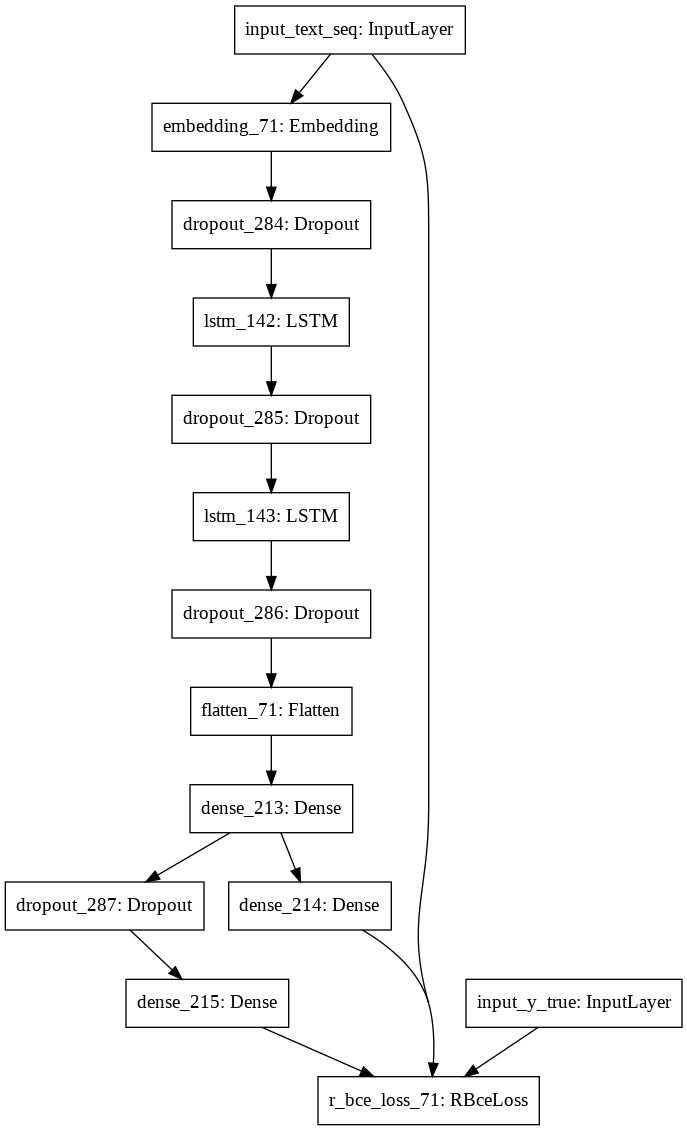

In [278]:
model, model_pred = lstm_model()
plot_model(model)

In [283]:
np.random.seed(1)
set_seed(2)
model, model_pred = lstm_model()
# model.summary()
# res_cusLSTM = model.fit([X, Y], epochs=1)
res_cusLSTM = model.fit([X, Y], epochs=23, shuffle=True, validation_split=0.2, batch_size=64)

Epoch 1/23
100/100 [==============================] - 5s 23ms/step - loss: 1.9967 - bce_loss: 0.7297 - rec_loss: 0.0641 - kl_loss: 0.5391 - quanti_loss: 0.6639 - val_loss: 1.4642 - val_bce_loss: 0.8280 - val_rec_loss: 0.0752 - val_kl_loss: 0.3358 - val_quanti_loss: 0.2251
Epoch 2/23
100/100 [==============================] - 2s 16ms/step - loss: 1.6213 - bce_loss: 0.8149 - rec_loss: 0.0737 - kl_loss: 0.3561 - quanti_loss: 0.3766 - val_loss: 2.0807 - val_bce_loss: 0.8432 - val_rec_loss: 0.0849 - val_kl_loss: 0.2872 - val_quanti_loss: 0.8655
Epoch 3/23
100/100 [==============================] - 2s 16ms/step - loss: 1.5136 - bce_loss: 0.8288 - rec_loss: 0.0735 - kl_loss: 0.3052 - quanti_loss: 0.3062 - val_loss: 2.3010 - val_bce_loss: 0.8019 - val_rec_loss: 0.0837 - val_kl_loss: 0.2610 - val_quanti_loss: 1.1544
Epoch 4/23
100/100 [==============================] - 2s 16ms/step - loss: 1.3987 - bce_loss: 0.8006 - rec_loss: 0.0705 - kl_loss: 0.2938 - quanti_loss: 0.2338 - val_loss: 1.4693 - 

In [276]:
# model.save('./models/CusLoss_2021_g50-2lstm32-fc16-23epo-64b-887.h5')
# model_pred.save('./models/CusLoss_2021_g50-2lstm32-fc16-23epo-64b-887_pre.h5')

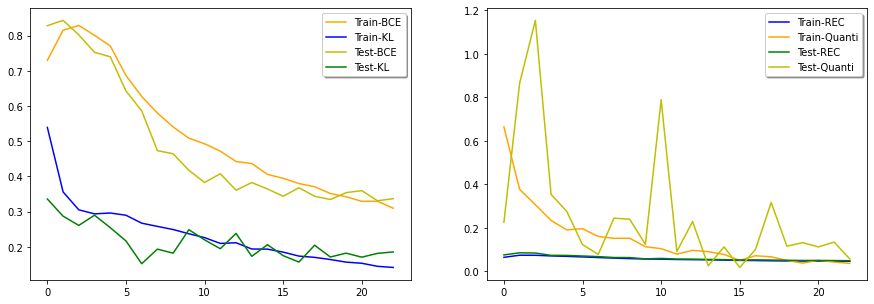

In [286]:
def VisRes(res):
    plt.figure(figsize=(15,5))
    plt.subplot('121')
    # plt.plot(list(res.history.values())[0],'magenta',label='Train-Loss')
    plt.plot(list(res.history.values())[1],'orange',label='Train-BCE')
    plt.plot(list(res.history.values())[3],'b',label='Train-KL')
    # plt.plot(list(res.history.values())[5],'cyan',label='Test-Loss')
    plt.plot(list(res.history.values())[6],'y',label='Test-BCE')
    plt.plot(list(res.history.values())[8],'g',label='Test-KL')
    plt.legend(loc='best', shadow=True)
    plt.subplot('122')
    plt.plot(list(res.history.values())[2],'b',label='Train-REC')
    plt.plot(list(res.history.values())[4],'orange',label='Train-Quanti')
    plt.plot(list(res.history.values())[7],'g',label='Test-REC')
    plt.plot(list(res.history.values())[9],'y',label='Test-Quanti')
    plt.legend(loc='best', shadow=True)
    plt.show()
VisRes(res_cusLSTM)

In [ ]:
X.shape, Y.shape

((8000, 68), (8000, 2))

### LSTM-orig

Epoch 1/23
100/100 [==============================] - 1s 14ms/step - loss: 0.7389 - accuracy: 0.7233 - val_loss: 0.5662 - val_accuracy: 0.8206
Epoch 2/23
100/100 [==============================] - 1s 11ms/step - loss: 0.5874 - accuracy: 0.8045 - val_loss: 0.4947 - val_accuracy: 0.8419
Epoch 3/23
100/100 [==============================] - 1s 11ms/step - loss: 0.5181 - accuracy: 0.8261 - val_loss: 0.4607 - val_accuracy: 0.8487
Epoch 4/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4729 - accuracy: 0.8328 - val_loss: 0.4131 - val_accuracy: 0.8650
Epoch 5/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4366 - accuracy: 0.8523 - val_loss: 0.3990 - val_accuracy: 0.8706
Epoch 6/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4116 - accuracy: 0.8583 - val_loss: 0.3835 - val_accuracy: 0.8763
Epoch 7/23
100/100 [==============================] - 1s 11ms/step - loss: 0.3843 - accuracy: 0.8675 - val_loss: 0.3723 - val_accuracy: 0.8825

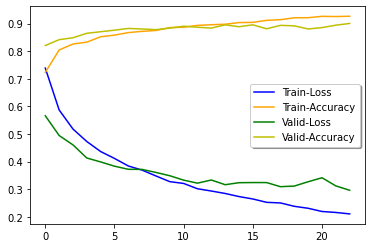

In [ ]:
# Glove + LSTM quick 
np.random.seed(1)
set_seed(2)
x = input_seq = Input(shape=(max_length, ))
x = Embedding(vocab_size, EMB_DIM, weights=[emb_matrix], trainable=True)(x)
x = Dropout(0.5)(x)
x = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
# r = Dense(68, activation='relu')(x)

# r = Dense(max_length, activation='relu')(x)
x = Dropout(0.1)(x)
y = Dense(2, activation='sigmoid')(x)


Model_lstm = Model(input_seq, y)
Model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
# Model_lstm.summary()
res_lstm_glove = Model_lstm.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)

def VisRes(res):
    plt.plot(list(res.history.values())[0],'b',label='Train-Loss')
    plt.plot(list(res.history.values())[1],'orange',label='Train-Accuracy')
    plt.plot(list(res.history.values())[2],'g',label='Valid-Loss')
    plt.plot(list(res.history.values())[3],'y',label='Valid-Accuracy')
    plt.legend(loc='best', shadow=True)
VisRes(res_lstm_glove) #2963 9044

Epoch 1/23
100/100 [==============================] - 8s 51ms/step - loss: 1.0878 - accuracy: 0.6119 - val_loss: 0.8897 - val_accuracy: 0.6056
Epoch 2/23
100/100 [==============================] - 4s 45ms/step - loss: 0.8375 - accuracy: 0.6270 - val_loss: 0.6589 - val_accuracy: 0.7088
Epoch 3/23
100/100 [==============================] - 4s 42ms/step - loss: 0.6294 - accuracy: 0.7390 - val_loss: 0.6097 - val_accuracy: 0.7494
Epoch 4/23
100/100 [==============================] - 4s 42ms/step - loss: 0.5348 - accuracy: 0.7787 - val_loss: 0.4819 - val_accuracy: 0.7875
Epoch 5/23
100/100 [==============================] - 4s 42ms/step - loss: 0.4897 - accuracy: 0.8051 - val_loss: 0.4279 - val_accuracy: 0.8294
Epoch 6/23
100/100 [==============================] - 4s 41ms/step - loss: 0.4635 - accuracy: 0.8176 - val_loss: 0.4289 - val_accuracy: 0.8062
Epoch 7/23
100/100 [==============================] - 4s 42ms/step - loss: 0.4374 - accuracy: 0.8317 - val_loss: 0.4074 - val_accuracy: 0.8363

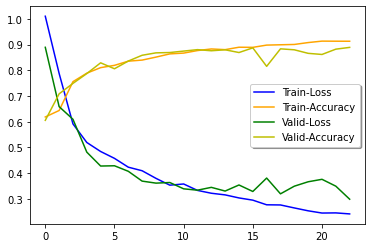

In [41]:
# Glove + LSTM * 2 quick & best 
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_lstm_glove = model.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove)

In [ ]:
# Model_lstm.save('./models/lstm_g50-lstm32-fc16-23epo-68batch-0.3602_603.h5')

# Evaluation on DEV set

In [61]:
dev = pd.read_csv(PATH+"public_dev.csv")
dev.loc[:,'tokens'] = [processText(t, rmStop=True) for t in dev.text]
dev.loc[:,'token_len'] = [len(t) for t in dev.tokens]
dev

/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,id,text,tokens,token_len
0,8001,What's the difference between a Bernie Sanders...,"['s, difference, bernie, sanders, supporter, f...",13
1,8002,"Vodka, whisky, tequila. I'm calling the shots.","[vodka, whisky, tequila, 'm, calling, shots]",6
2,8003,French people don't masturbate They Jacque off,"[french, people, n't, masturbate, jacque]",5
3,8004,A lot of Suicide bombers are Muslims - I don't...,"[lot, suicide, bombers, muslims, -, n't, blame...",11
4,8005,What happens when you fingerbang a gypsy on he...,"[happens, fingerbang, gypsy, period, ?, get, p...",8
...,...,...,...,...
995,8996,boss: what are you doing inventor of the bagpi...,"[boss, :, inventor, bagpipes, :, no, fucking, ...",8
996,8997,I told him his views were pretty extreme and i...,"[told, views, pretty, extreme, would, benefici...",12
997,8998,"""Mum, all the black kids call each other Nigga...","[``, mum, black, kids, call, nigga, call, get,...",16
998,8999,"In honor of Fathers Day, I'm gonna bring you ""...","[honor, fathers, day, 'm, gon, na, bring, ``, ...",40


In [62]:
X_dev, vocab_size_dev, max_length_dev = encodeText(dev['tokens'], max_len=max_length)
X_dev.shape, vocab_size_dev, max_length_dev

((1000, 68), 14766, 68)

In [63]:
# True value of dev set
y_dev = pd.read_csv(PATH+'dev.csv')
y_dev.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,8001,What's the difference between a Bernie Sanders...,1,2.45,0.0,1.70
1,8002,"Vodka, whisky, tequila. I'm calling the shots.",1,2.00,0.0,0.00
2,8003,French people don't masturbate They Jacque off,1,2.95,0.0,1.15
3,8004,A lot of Suicide bombers are Muslims - I don't...,1,1.38,0.0,3.75
4,8005,What happens when you fingerbang a gypsy on he...,1,2.70,1.0,2.25


## Dev results

In [287]:
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
print(f1_score(y_pred,y_dev.is_humor),accuracy_score(y_pred,y_dev.is_humor))
print(classification_report(y_pred, y_dev.is_humor))

0.8875562218890555 0.85
              precision    recall  f1-score   support

           0       0.70      0.87      0.77       298
           1       0.94      0.84      0.89       702

    accuracy                           0.85      1000
   macro avg       0.82      0.85      0.83      1000
weighted avg       0.87      0.85      0.85      1000



In [ ]:
# 8821 845 bce+rec+quan+y_ban+kl, 879 842 bce+quan+rec, 873 835 bce+quan, 8798 843 bce+rec,  8819 845 bce+rec(abs/sqr), 879 843 bce
# 875 843 bce+quan+rec(abs/sqr), 880 844 bce+quan+rec(sqr/sqr)
# 8845 851 bce+rec(sqr)+quan+kl, 887 853 bce+rec(abs)+kl+quan,

In [48]:
# task 1a
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #lstm2 emb+fc16:/622/623 emb:646,  y_balance+abs609 square606 y_bala+squ+quanti(r-y_true)608 ...(r-y_true)601

1    681
0    319
dtype: int64

In [ ]:
# task 1a
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #lstm2 emb+fc16:/622/623 emb:646,  y_balance+abs609 square606 y_bala+squ+quanti(r-y_true)608 ...(r-y_true)601

1    668
0    332
dtype: int64

In [ ]:
output = pd.DataFrame(dev.loc[:,'id'])
output.loc[:,'is_humor'] = y_pred
compression_opts = dict(method='zip', archive_name='res.csv')  
output.to_csv('zehao_liu_dev37_lstm2_g100d0.7_fc16_617_rec_bal_quantiYTrue.zip', index=None, compression=compression_opts)